In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import os

In [2]:
class BaseTemplate(maf.BaseMetric):
    """Determine how many images have templates. 
    
    Parameters
    ----------
    n_needed : int (5)
    """
    def __init__(self, n_needed=3, mjd_col="observationStartMJD", seeing_col="seeingFwhmGeom",
        metric_name="Base_template", seeing_limit=0.9, cols=None, **kwargs):
        self.n_needed = n_needed
        if cols is None:
            cols = [mjd_col, seeing_col]
        self.seeing_limit = seeing_limit
        super(BaseTemplate, self).__init__(
            col=cols, metric_name=metric_name, units="N"
        )
        self.mjd_col = mjd_col
        self.seeing_col = seeing_col
        
    def _visits_w_templates(self, data_slice):
        seeing_met = np.where(data_slice[self.seeing_col] <= self.seeing_limit)[0]
        if np.size(seeing_met) < (self.n_needed+1):
            return self.badval, False
        after_built = seeing_met[self.n_needed]
        if np.size(after_built) == 0:
            return self.badval, False
        return data_slice[after_built:-1], True
    
        
    def run(self, data_slice, slice_point=None):
        data_slice.sort(order=self.mjd_col)
        
        
        pass
    
class FirstNightTemplate(BaseTemplate):
    def __init__(self, n_needed=3, mjd_col="observationStartMJD", seeing_col="seeingFwhmGeom",
        metric_name="FirstNightTemplate",  night_col="night", **kwargs):
        cols = [mjd_col, seeing_col, night_col]
        super(FirstNightTemplate, self).__init__(
            cols=cols, metric_name=metric_name, units="N", **kwargs
        )
        self.night_col = night_col
        
        
    def run(self, data_slice, slice_point=None):
        data_slice.sort(order=self.mjd_col)
        ab, good = self._visits_w_templates(data_slice)
        
        if not good:
            return self.badval
        if np.size(ab) > 0:
            return np.min(ab[self.night_col])
        else:
            return self.badval
        
        
class NAfterTemplate(BaseTemplate):
    def __init__(self, n_needed=3, mjd_col="observationStartMJD", seeing_col="seeingFwhmGeom",
        metric_name="NAfterTemplate",  night_col="night", **kwargs):
        cols = [mjd_col, seeing_col, night_col]
        super(NAfterTemplate, self).__init__(
            cols=cols, metric_name=metric_name, units="N", **kwargs
        )
        self.night_col = night_col
        
        
    def run(self, data_slice, slice_point=None):
        data_slice.sort(order=self.mjd_col)
        ab, good = self._visits_w_templates(data_slice)
        
        if not good:
            return self.badval
        if np.size(ab) > 0:
            return np.size(ab[self.night_col])
        else:
            return self.badval
        
        

In [3]:
baseline = get_baseline()
run_name = os.path.basename(baseline).replace('.db', '')
bundle_list = []

sql = 'filter="g" and night < 366 and note not like "%DD%" and visitExposureTime > 20'
metric = FirstNightTemplate(seeing_limit=5)
slicer = maf.HealpixSlicer()
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name))

metric = NAfterTemplate(seeing_limit=5)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name))

metric = maf.CountMetric(col="night", metric_name="count")
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name))



Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


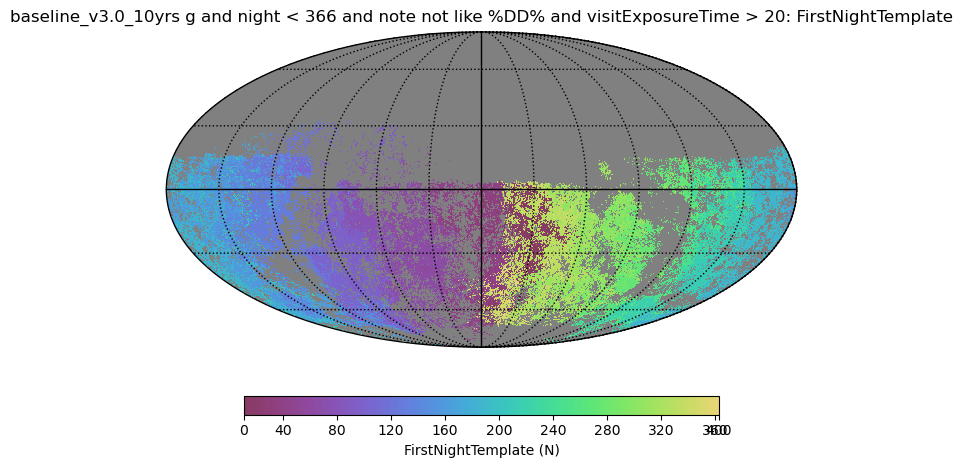

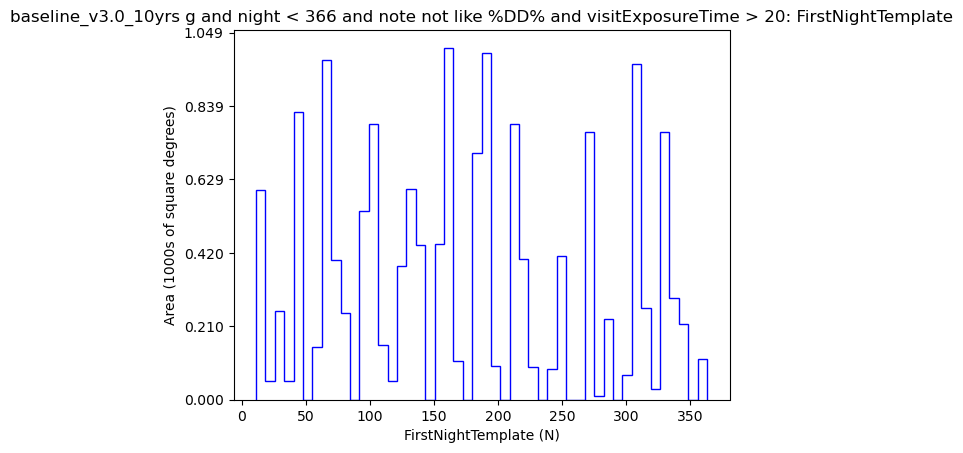

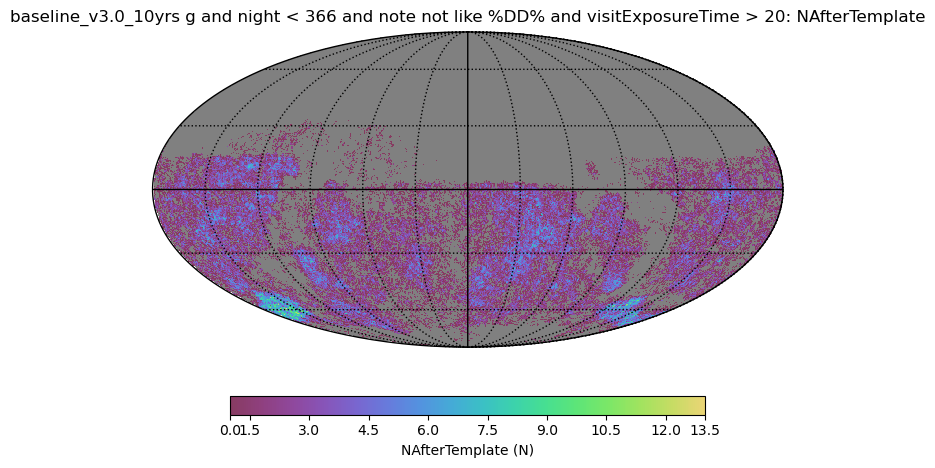

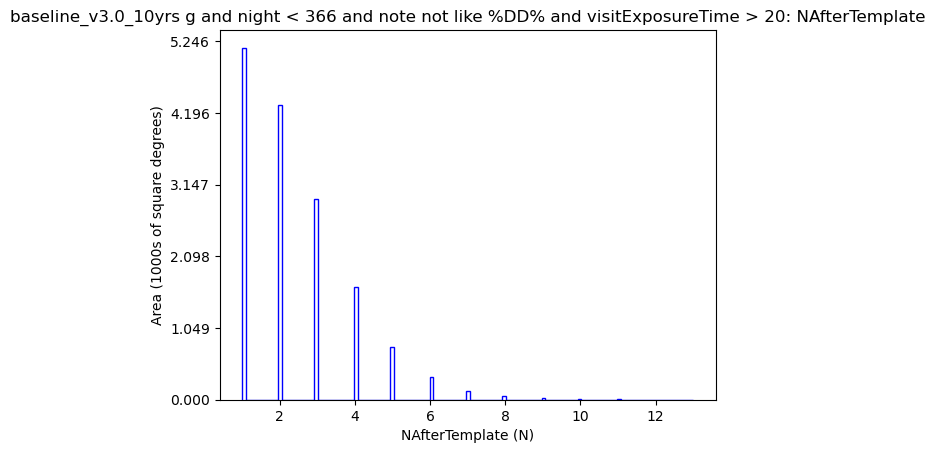

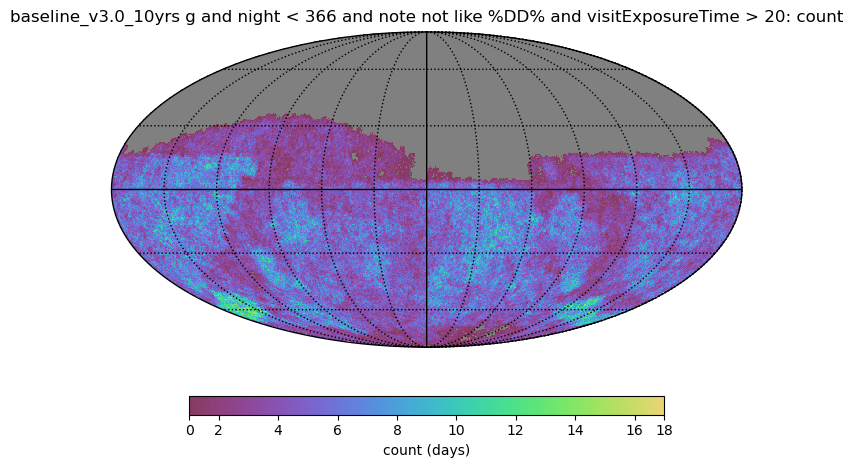

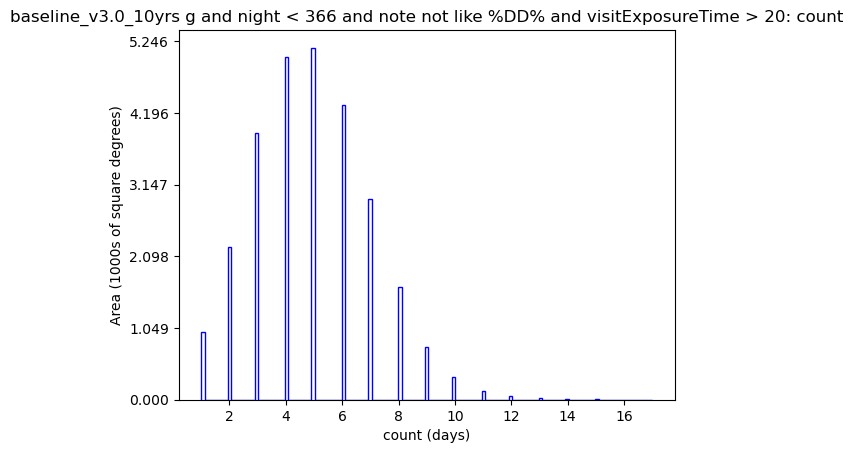

In [4]:
bg = maf.MetricBundleGroup(bundle_list, baseline, out_dir='temp',results_db=None)
bg.run_all()
bg.plot_all(closefigs=False)